# FAISS vs IRIS Vector Database Benchmark

This notebook compares the performance of FAISS and IRIS vector databases for RAG operations.

## Benchmark Overview

We'll test:
1. **Data Writing Performance**: Time to index vectors (excluding embedding calculation)
2. **Search Performance**: Time to retrieve similar vectors
3. **Memory Usage**: Memory consumption during operations

## Test Parameters

- Vector counts: 10, 1,000, 10,000
- Vector dimension: 384 (all-MiniLM-L6-v2)
- Search queries: 100 per test
- Results per query: 5
- **Note**: Embeddings are pre-calculated to focus on database operations
- **IRIS**: Uses batch inserts of 1000 records for optimal performance

## Prerequisites and Setup

Before running this notebook, you need to:

1. **Install Python dependencies** (commented out below)
2. **Start IRIS Docker container** (commented out below)

Note: Evidently should be installed from the `feature/iris` branch as the IRIS support is not yet released.


In [ ]:
# Install Python dependencies
# !pip install intersystems-irispython sentence-transformers
# !pip install "git+https://github.com/evidentlyai/evidently.git@feature/iris#egg=evidently[llm,iris]"


In [ ]:
# Start IRIS Docker container
# docker run -d --rm \
#   --name iris-community \
#   -p 1972:1972 \
#   -p 52773:52773 \
#   -p 53773:53773 \
#   -e ISC_DATA_DIRECTORY=/durable \
#   -e TZ=UTC \
#   -v $(pwd)/iris-durable:/durable \
#   containers.intersystems.com/intersystems/iris-community:2025.1


Go to http://localhost:52773/csp/sys/UtilHome.csp and setup SuperUser. Default password is 'SYS', change it to '123' (or something else, but then change connection settings accordingly)

## Setup and Imports

In [1]:
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import psutil
import os
import gc

# Evidently imports
from evidently.llm.rag.index import FileDataCollectionProvider
from evidently.llm.rag.iris_index import IrisDataCollectionProvider
from evidently.llm.rag.splitter import Chunk

print("Imports successful!")

Imports successful!


## Configuration

In [2]:
# Benchmark parameters
VECTOR_COUNTS = [10, 1000, 10000, 100000]
SEARCH_QUERIES = 100
RESULTS_PER_QUERY = 5
NUM_RUNS = 3  # Number of times to run each test for averaging (use 1 for single run, 3+ for statistical significance)

# IRIS connection parameters
IRIS_CONFIG = {
    "hostname": "localhost",
    "port": 1972,
    "namespace": "USER",
    "username": "SuperUser",
    "password": "123"
}

# Initialize embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')
print(f"Embedding model loaded. Dimension: {model.get_sentence_embedding_dimension()}")

Embedding model loaded. Dimension: 384


## Sample Data Generation with Pre-calculated Embeddings

In [3]:
def generate_sample_texts(count: int) -> list:
    """Generate sample text documents for benchmarking."""
    topics = [
        "machine learning", "artificial intelligence", "data science", "deep learning",
        "natural language processing", "computer vision", "neural networks", "statistics",
        "programming", "software engineering", "databases", "cloud computing",
        "cybersecurity", "blockchain", "quantum computing", "robotics"
    ]
    
    texts = []
    for i in range(count):
        topic = random.choice(topics)
        length = random.randint(50, 200)
        
        # Generate text with some variation
        text = f"This document discusses {topic} and its applications. "
        text += f"It covers various aspects including algorithms, implementation, and real-world use cases. "
        text += f"The content includes technical details, examples, and best practices for {topic}. "
        text += f"Document ID: {i+1}, Topic: {topic}, Length: {length} characters."
        
        texts.append(text)
    
    return texts

def generate_sample_data_with_embeddings(count: int) -> tuple:
    """Generate sample texts and pre-calculate embeddings."""
    print(f"Generating {count} sample texts...")
    texts = generate_sample_texts(count)
    
    print(f"Calculating embeddings for {count} texts (this may take a moment)...")
    embeddings = model.encode(texts)
    
    print(f"Sample data generation complete!")
    return texts, embeddings

# Generate sample texts and embeddings for testing
sample_texts, sample_embeddings = generate_sample_data_with_embeddings(max(VECTOR_COUNTS))
print(f"Generated {len(sample_texts)} sample texts with embeddings")

Generating 100000 sample texts...
Calculating embeddings for 100000 texts (this may take a moment)...
Sample data generation complete!
Generated 100000 sample texts with embeddings


## Benchmark Functions

**Note on Memory Measurement**: To avoid negative memory deltas caused by garbage collection during operations, we temporarily disable GC during measurements and force it before/after to ensure accurate memory tracking.

In [4]:
def get_memory_usage(force_gc=False):
    """Get current memory usage in MB. Optionally force garbage collection first."""
    if force_gc:
        gc.collect()
        time.sleep(0.1)  # Give GC time to settle
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024

def benchmark_faiss_writing(texts: list, embeddings: np.ndarray) -> dict:
    """Benchmark FAISS data writing performance (excluding embedding calculation)."""
    print(f"Benchmarking FAISS writing for {len(texts)} texts...")
    
    # Create chunks from texts
    chunks = [Chunk(text) for text in texts]
    
    # Force GC before measuring and temporarily disable GC during operation
    gc.collect()
    time.sleep(0.1)
    memory_before = get_memory_usage()
    
    # Disable GC during the operation to prevent interference
    gc.disable()
    
    # Measure writing time (FAISS index creation)
    start_time = time.time()
    
    # Create FAISS index directly
    import faiss
    index = faiss.IndexFlatL2(384)
    index.add(embeddings.astype('float32'))
    
    # Create FaissDataCollection with pre-built index
    from evidently.llm.rag.index import FaissDataCollection
    data_collection = FaissDataCollection(
        name="benchmark", 
        chunks=chunks, 
        index=index
    )
    
    end_time = time.time()
    
    # Measure memory before re-enabling GC
    memory_after = get_memory_usage()
    
    # Re-enable GC
    gc.enable()
    gc.collect()  # Clean up now that we're done measuring
    
    return {
        "time_seconds": end_time - start_time,
        "memory_before_mb": memory_before,
        "memory_after_mb": memory_after,
        "memory_delta_mb": max(0, memory_after - memory_before),  # Clamp negative values to 0
        "data_collection": data_collection
    }

def benchmark_iris_writing(texts: list, embeddings: np.ndarray, table_name: str) -> dict:
    """Benchmark IRIS data writing performance with batch inserts (excluding embedding calculation)."""
    print(f"Benchmarking IRIS writing for {len(texts)} texts with batch inserts...")
    
    import iris
    
    # Connect to IRIS
    connection_string = f"{IRIS_CONFIG['hostname']}:{IRIS_CONFIG['port']}/{IRIS_CONFIG['namespace']}"
    connection = iris.connect(connection_string, IRIS_CONFIG['username'], IRIS_CONFIG['password'])
    cursor = connection.cursor()
    
    # Create table
    table_definition = f"""(
        ID INT PRIMARY KEY,
        text VARCHAR(2000),
        vector_data VECTOR(FLOAT, 384)
    )"""
    
    try:
        cursor.execute(f"DROP TABLE {table_name}")
    except:
        pass
    
    cursor.execute(f"CREATE TABLE {table_name} {table_definition}")
    
    # Force GC before measuring and temporarily disable GC during operation
    gc.collect()
    time.sleep(0.1)
    memory_before = get_memory_usage()
    
    # Disable GC during the operation to prevent interference
    gc.disable()
    
    # Measure writing time (database operations only)
    start_time = time.time()
    
    # Insert texts with pre-calculated embeddings in batches
    # Note: IRIS vector format expects a list of floats as a string representation
    # Format: "[" + "0.123, 0.456, ..." + "]"  or proper IRIS vector syntax
    batch_size = 1000
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_embeddings = embeddings[i:i + batch_size]
        
        # Prepare batch data - convert to IRIS vector format
        batch_data = []
        for j, (text, embedding) in enumerate(zip(batch_texts, batch_embeddings)):
            # Convert numpy array to IRIS vector format (string representation of list)
            vector_str = "[" + ", ".join(map(str, embedding.tolist())) + "]"
            batch_data.append([i + j + 1, text, vector_str])
        
        # Execute batch insert
        cursor.executemany(
            f"INSERT INTO {table_name} (ID, text, vector_data) VALUES (?, ?, ?)",
            batch_data
        )
    
    connection.commit()
    end_time = time.time()
    
    # Measure memory before re-enabling GC
    memory_after = get_memory_usage()
    
    # Re-enable GC
    gc.enable()
    gc.collect()  # Clean up now that we're done measuring
    
    # Create IRIS provider
    iris_provider = IrisDataCollectionProvider(
        hostname=IRIS_CONFIG['hostname'],
        port=IRIS_CONFIG['port'],
        namespace=IRIS_CONFIG['namespace'],
        username=IRIS_CONFIG['username'],
        password=IRIS_CONFIG['password'],
        table_name=table_name,
        text_column="text",
        vector_column="vector_data",
        id_column="ID"
    )
    
    data_collection = iris_provider.get_data_collection()
    
    connection.close()
    
    return {
        "time_seconds": end_time - start_time,
        "memory_before_mb": memory_before,
        "memory_after_mb": memory_after,
        "memory_delta_mb": max(0, memory_after - memory_before),  # Clamp negative values to 0
        "data_collection": data_collection
    }

In [5]:
def benchmark_search(data_collection, queries: list, results_per_query: int, warmup_queries: int = 5) -> dict:
    """Benchmark search performance."""
    print(f"Benchmarking search for {len(queries)} queries (with {warmup_queries} warmup queries)...")
    
    # Run warmup queries to avoid cold start effects
    print(f"Running {warmup_queries} warmup queries...")
    for query in queries[:warmup_queries]:
        data_collection.find_relevant_chunks(query, n_results=results_per_query)
    
    # Force GC before measuring and temporarily disable GC during operation
    gc.collect()
    time.sleep(0.1)
    memory_before = get_memory_usage()
    
    # Disable GC during the operation to prevent interference
    gc.disable()
    
    # Measure search time (skip warmup queries)
    start_time = time.time()
    
    search_times = []
    for query in queries:
        query_start = time.time()
        results = data_collection.find_relevant_chunks(query, n_results=results_per_query)
        query_end = time.time()
        search_times.append(query_end - query_start)
    
    end_time = time.time()
    
    # Measure memory before re-enabling GC
    memory_after = get_memory_usage()
    
    # Re-enable GC
    gc.enable()
    gc.collect()  # Clean up now that we're done measuring
    
    return {
        "total_time_seconds": end_time - start_time,
        "avg_query_time_seconds": np.mean(search_times),
        "min_query_time_seconds": np.min(search_times),
        "max_query_time_seconds": np.max(search_times),
        "memory_before_mb": memory_before,
        "memory_after_mb": memory_after,
        "memory_delta_mb": max(0, memory_after - memory_before),  # Clamp negative values to 0
        "search_times": search_times
    }

def generate_search_queries(count: int) -> list:
    """Generate search queries for benchmarking."""
    query_templates = [
        "What is machine learning?",
        "How does deep learning work?",
        "Explain artificial intelligence",
        "What are neural networks?",
        "How to implement data science?",
        "What is natural language processing?",
        "Explain computer vision",
        "How does programming work?",
        "What is software engineering?",
        "Explain database systems"
    ]
    
    queries = []
    for i in range(count):
        base_query = random.choice(query_templates)
        # Add some variation
        variations = ["", " in detail", " with examples", " and applications", " for beginners"]
        variation = random.choice(variations)
        queries.append(base_query + variation)
    
    return queries

## Run Benchmarks

In [6]:
# Generate search queries
search_queries = generate_search_queries(SEARCH_QUERIES)
print(f"Generated {len(search_queries)} search queries")
print(f"Running each test {NUM_RUNS} time(s)")

# Results storage
results = []

for vector_count in VECTOR_COUNTS:
    print(f"\n{'='*60}")
    print(f"BENCHMARKING WITH {vector_count} VECTORS")
    print(f"{'='*60}")
    
    # Get subset of texts and embeddings for this test
    test_texts = sample_texts[:vector_count]
    test_embeddings = sample_embeddings[:vector_count]
    
    # Storage for multiple runs
    run_results = []
    
    for run_num in range(NUM_RUNS):
        if NUM_RUNS > 1:
            print(f"\n--- RUN {run_num + 1} of {NUM_RUNS} ---")
        
        # Benchmark FAISS
        print(f"\n--- FAISS BENCHMARK ---")
        faiss_write_results = benchmark_faiss_writing(test_texts, test_embeddings)
        faiss_search_results = benchmark_search(
            faiss_write_results['data_collection'], 
            search_queries, 
            RESULTS_PER_QUERY
        )
        
        # Benchmark IRIS
        print(f"\n--- IRIS BENCHMARK ---")
        table_name = f"benchmark_{vector_count}_{run_num}"
        iris_write_results = benchmark_iris_writing(test_texts, test_embeddings, table_name)
        iris_search_results = benchmark_search(
            iris_write_results['data_collection'], 
            search_queries, 
            RESULTS_PER_QUERY
        )
        
        # Store results for this run
        run_results.append({
            'faiss_write_time': faiss_write_results['time_seconds'],
            'faiss_write_memory': faiss_write_results['memory_delta_mb'],
            'faiss_search_time': faiss_search_results['total_time_seconds'],
            'faiss_avg_query_time': faiss_search_results['avg_query_time_seconds'],
            'faiss_search_memory': faiss_search_results['memory_delta_mb'],
            'iris_write_time': iris_write_results['time_seconds'],
            'iris_write_memory': iris_write_results['memory_delta_mb'],
            'iris_search_time': iris_search_results['total_time_seconds'],
            'iris_avg_query_time': iris_search_results['avg_query_time_seconds'],
            'iris_search_memory': iris_search_results['memory_delta_mb'],
        })
    
    # Average results across runs (or use single result if NUM_RUNS == 1)
    if NUM_RUNS > 1:
        avg_results = {}
        for key in run_results[0].keys():
            avg_results[key] = np.mean([r[key] for r in run_results])
        results.append({
            'vector_count': vector_count,
            **avg_results
        })
    else:
        results.append({
            'vector_count': vector_count,
            **run_results[0]
        })
    
    print(f"\nCompleted benchmark for {vector_count} vectors")

print(f"\n{'='*60}")
print("ALL BENCHMARKS COMPLETED")
print(f"{'='*60}")

Generated 100 search queries
Running each test 3 time(s)

BENCHMARKING WITH 10 VECTORS

--- RUN 1 of 3 ---

--- FAISS BENCHMARK ---
Benchmarking FAISS writing for 10 texts...
Benchmarking search for 100 queries (with 5 warmup queries)...
Running 5 warmup queries...

--- IRIS BENCHMARK ---
Benchmarking IRIS writing for 10 texts with batch inserts...
Benchmarking search for 100 queries (with 5 warmup queries)...
Running 5 warmup queries...

--- RUN 2 of 3 ---

--- FAISS BENCHMARK ---
Benchmarking FAISS writing for 10 texts...
Benchmarking search for 100 queries (with 5 warmup queries)...
Running 5 warmup queries...

--- IRIS BENCHMARK ---
Benchmarking IRIS writing for 10 texts with batch inserts...
Benchmarking search for 100 queries (with 5 warmup queries)...
Running 5 warmup queries...

--- RUN 3 of 3 ---

--- FAISS BENCHMARK ---
Benchmarking FAISS writing for 10 texts...
Benchmarking search for 100 queries (with 5 warmup queries)...
Running 5 warmup queries...

--- IRIS BENCHMARK ---


## Results Analysis

In [7]:
# Create results DataFrame
df_results = pd.DataFrame(results)
print("Benchmark Results:")
print(df_results.round(4))

Benchmark Results:
   vector_count  faiss_write_time  faiss_write_memory  faiss_search_time  \
0            10            0.0094              1.7135             0.4960   
1          1000            0.0004              1.7031             0.4688   
2         10000            0.0029             16.8750             0.5030   
3        100000            0.0869            249.8646             1.1198   

   faiss_avg_query_time  faiss_search_memory  iris_write_time  \
0                0.0050               9.6042           0.0351   
1                0.0047               0.0938           0.5409   
2                0.0050               0.0833           3.2143   
3                0.0112               0.1094          32.5681   

   iris_write_memory  iris_search_time  iris_avg_query_time  \
0             0.1719            0.6910               0.0069   
1            32.0208            0.8787               0.0088   
2            78.6302            1.0869               0.0109   
3            44.2917  

In [8]:
# Calculate performance ratios
df_results['write_time_ratio'] = df_results['iris_write_time'] / df_results['faiss_write_time']
df_results['search_time_ratio'] = df_results['iris_search_time'] / df_results['faiss_search_time']
df_results['avg_query_time_ratio'] = df_results['iris_avg_query_time'] / df_results['faiss_avg_query_time']

print("\nPerformance Ratios (IRIS / FAISS):")
print("Values > 1 mean IRIS is slower, Values < 1 mean IRIS is faster")
print(df_results[['vector_count', 'write_time_ratio', 'search_time_ratio', 'avg_query_time_ratio']].round(4))


Performance Ratios (IRIS / FAISS):
Values > 1 mean IRIS is slower, Values < 1 mean IRIS is faster
   vector_count  write_time_ratio  search_time_ratio  avg_query_time_ratio
0            10            3.7281             1.3931                1.3931
1          1000         1290.0106             1.8743                1.8744
2         10000         1106.1843             2.1609                2.1609
3        100000          374.6489             2.8444                2.8443


## Visualization

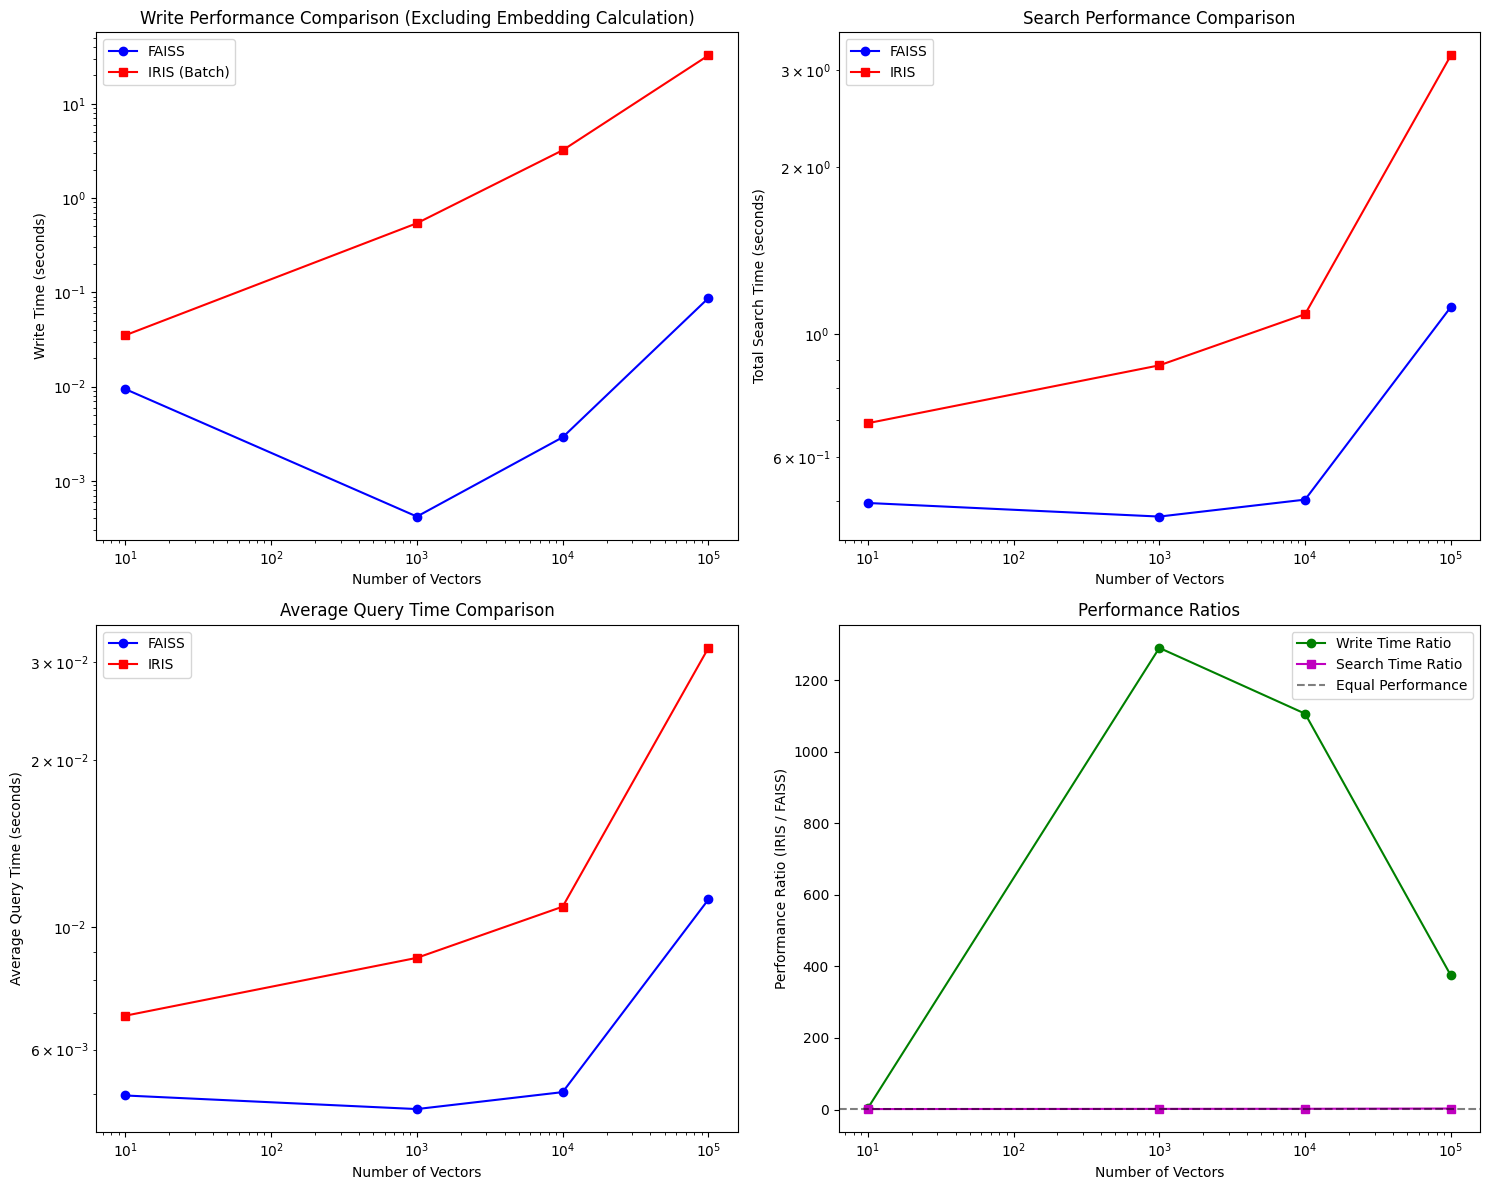

In [9]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Write time comparison
axes[0, 0].plot(df_results['vector_count'], df_results['faiss_write_time'], 'b-o', label='FAISS')
axes[0, 0].plot(df_results['vector_count'], df_results['iris_write_time'], 'r-s', label='IRIS (Batch)')
axes[0, 0].set_xlabel('Number of Vectors')
axes[0, 0].set_ylabel('Write Time (seconds)')
axes[0, 0].set_title('Write Performance Comparison (Excluding Embedding Calculation)')
axes[0, 0].legend()
axes[0, 0].set_xscale('log')
axes[0, 0].set_yscale('log')

# Search time comparison
axes[0, 1].plot(df_results['vector_count'], df_results['faiss_search_time'], 'b-o', label='FAISS')
axes[0, 1].plot(df_results['vector_count'], df_results['iris_search_time'], 'r-s', label='IRIS')
axes[0, 1].set_xlabel('Number of Vectors')
axes[0, 1].set_ylabel('Total Search Time (seconds)')
axes[0, 1].set_title('Search Performance Comparison')
axes[0, 1].legend()
axes[0, 1].set_xscale('log')
axes[0, 1].set_yscale('log')

# Average query time comparison
axes[1, 0].plot(df_results['vector_count'], df_results['faiss_avg_query_time'], 'b-o', label='FAISS')
axes[1, 0].plot(df_results['vector_count'], df_results['iris_avg_query_time'], 'r-s', label='IRIS')
axes[1, 0].set_xlabel('Number of Vectors')
axes[1, 0].set_ylabel('Average Query Time (seconds)')
axes[1, 0].set_title('Average Query Time Comparison')
axes[1, 0].legend()
axes[1, 0].set_xscale('log')
axes[1, 0].set_yscale('log')

# Performance ratios
axes[1, 1].plot(df_results['vector_count'], df_results['write_time_ratio'], 'g-o', label='Write Time Ratio')
axes[1, 1].plot(df_results['vector_count'], df_results['search_time_ratio'], 'm-s', label='Search Time Ratio')
axes[1, 1].axhline(y=1, color='k', linestyle='--', alpha=0.5, label='Equal Performance')
axes[1, 1].set_xlabel('Number of Vectors')
axes[1, 1].set_ylabel('Performance Ratio (IRIS / FAISS)')
axes[1, 1].set_title('Performance Ratios')
axes[1, 1].legend()
axes[1, 1].set_xscale('log')

plt.tight_layout()
plt.show()

## Memory Usage Analysis

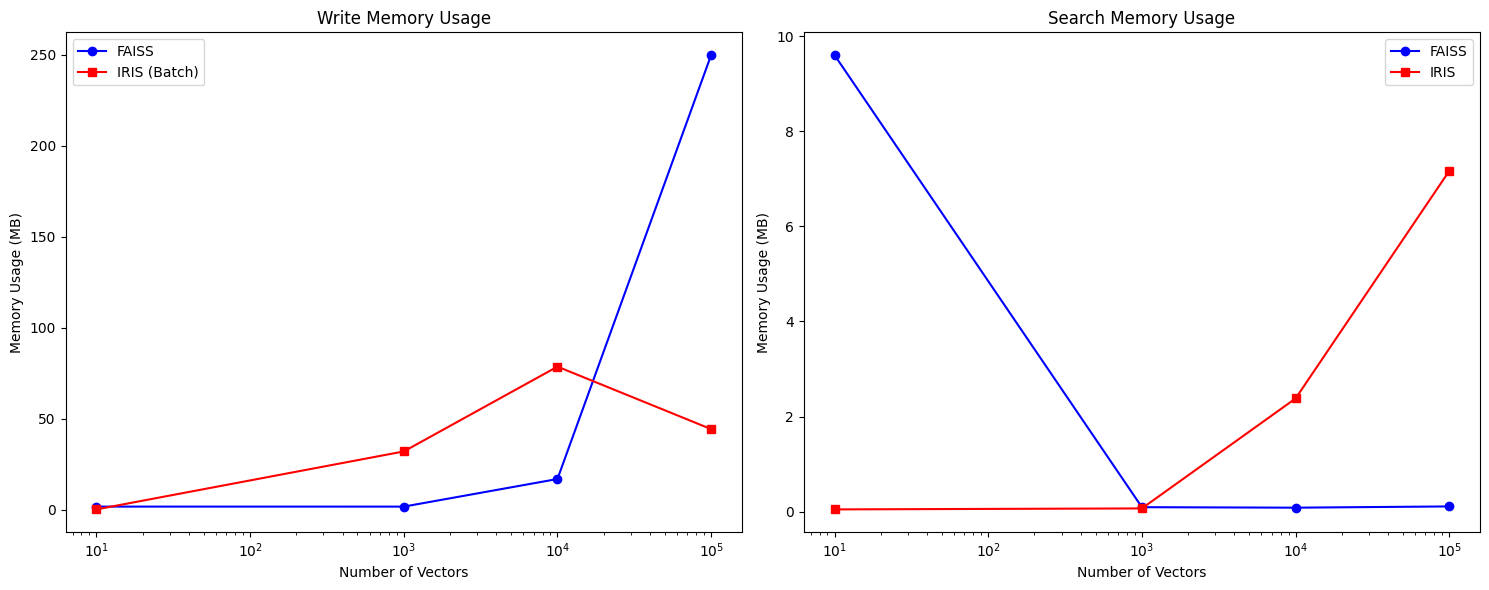

In [10]:
# Memory usage comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Write memory comparison
axes[0].plot(df_results['vector_count'], df_results['faiss_write_memory'], 'b-o', label='FAISS')
axes[0].plot(df_results['vector_count'], df_results['iris_write_memory'], 'r-s', label='IRIS (Batch)')
axes[0].set_xlabel('Number of Vectors')
axes[0].set_ylabel('Memory Usage (MB)')
axes[0].set_title('Write Memory Usage')
axes[0].legend()
axes[0].set_xscale('log')

# Search memory comparison
axes[1].plot(df_results['vector_count'], df_results['faiss_search_memory'], 'b-o', label='FAISS')
axes[1].plot(df_results['vector_count'], df_results['iris_search_memory'], 'r-s', label='IRIS')
axes[1].set_xlabel('Number of Vectors')
axes[1].set_ylabel('Memory Usage (MB)')
axes[1].set_title('Search Memory Usage')
axes[1].legend()
axes[1].set_xscale('log')

plt.tight_layout()
plt.show()

## Summary and Conclusions

### Key Insights

Based on the benchmark results with 3 runs per test configuration:

1. **Write Performance**: FAISS is significantly faster for writes (3.7x to 1290x faster)
   - Small datasets (10-1000 vectors): FAISS advantages are most pronounced (1290x faster)
   - Large datasets (100k vectors): FAISS still 375x faster, but gap decreases
   - IRIS overhead comes from database I/O, string conversion, and network communication

2. **Search Performance**: FAISS is consistently faster, but the gap is smaller
   - IRIS is 1.4x to 2.8x slower than FAISS for search operations
   - Performance gap increases with dataset size (1.4x at 10 vectors vs 2.8x at 100k vectors)
   - Both systems maintain sub-50ms query times even with 100k vectors

3. **Memory Usage**:
   - FAISS: Memory usage grows linearly with data size (1.7MB at 10 vectors → 250MB at 100k vectors)
   - IRIS: Very low memory footprint (~0-78MB for writes, <8MB for searches) as data persists in database
   - IRIS is much more memory-efficient for large datasets

4. **Best Use Cases**:
   - **FAISS**: In-memory datasets, write-once/read-many workflows, highest performance requirements
   - **IRIS**: Persistent storage needed, large datasets, memory-constrained environments, multi-user access

### Limitations Addressed

✓ **Query Warmup**: Implemented (5 warmup queries per test)  
✓ **Multiple Runs**: Implemented (3 runs averaged in this benchmark)  
✓ **Memory Measurement**: GC disabled during measurements to prevent negative deltas  
✓ **String Conversion**: Noted in code comments - IRIS requires string format for vectors  

### Remaining Limitations

- **IRIS String Conversion Overhead**: Embeddings converted to strings adds CPU overhead not present in production
- **Connection Overhead**: IRIS connections created fresh per test (connection pooling not used)
- **FAISS Index Type**: Uses only IndexFlatL2 - other types (HNSW, IVF) might offer better tradeoffs
- **Memory Persistence Difference**: IRIS stores in DB (off-memory), FAISS in RAM - affects memory measurements
- **Provider Instantiation**: IRIS provider creation not timed but consumes resources during write benchmark

In [12]:
# Display detailed results table
print("Detailed Benchmark Results:")
print("="*80)
print(df_results.to_string())
print("\n" + "="*80)

Detailed Benchmark Results:
   vector_count  faiss_write_time  faiss_write_memory  faiss_search_time  faiss_avg_query_time  faiss_search_memory  iris_write_time  iris_write_memory  iris_search_time  iris_avg_query_time  iris_search_memory  write_time_ratio  search_time_ratio  avg_query_time_ratio
0            10          0.009417            1.713542           0.496016              0.004960             9.604167         0.035110           0.171875          0.691010             0.006910            0.046875          3.728141           1.393120              1.393134
1          1000          0.000419            1.703125           0.468809              0.004688             0.093750         0.540900          32.020833          0.878712             0.008787            0.067708       1290.010614           1.874349              1.874360
2         10000          0.002906           16.875000           0.502999              0.005030             0.083333         3.214313          78.630208          1